In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import gym
import tqdm

In [18]:
train_env = gym.make('CartPole-v1')
test_env = gym.make('CartPole-v1')

In [19]:
SEED = 1234

train_env.seed(SEED);
test_env.seed(SEED+1);
np.random.seed(SEED);
torch.manual_seed(SEED);

In [20]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        return x

In [21]:
class ActorCritic(nn.Module):
    def __init__(self, actor, critic):
        super().__init__()
        
        self.actor = actor
        self.critic = critic
        
    def forward(self, state):
        
        action_pred = self.actor(state)
        value_pred = self.critic(state)
        
        return action_pred, value_pred

In [22]:
input_dim = train_env.observation_space.shape[0]
hidden_dim = 32
output_dim = train_env.action_space.n

In [23]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0)

In [24]:
device = torch.device('cuda')

In [25]:
def train(env, policy, optimizer, discount_factor, device):
    
    policy.train()
    
    log_prob_actions = []
    entropies = []
    value_preds = []
    rewards = []
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:

        state = torch.FloatTensor(state).unsqueeze(0).to(device)

        action_pred, value_pred = policy(state)
        
        action_prob = F.softmax(action_pred, dim = -1)
                
        dist = distributions.Categorical(action_prob)

        action = dist.sample()
        log_prob_action = dist.log_prob(action)
        
        entropy = dist.entropy()

        state, reward, done, _ = env.step(action.item())

        log_prob_actions.append(log_prob_action)
        entropies.append(entropy)
        value_preds.append(value_pred.squeeze(0))
        rewards.append(reward)

        episode_reward += reward

    log_prob_actions = torch.cat(log_prob_actions)
    entropies = torch.cat(entropies)
    value_preds = torch.cat(value_preds)
        
    returns = calculate_returns(rewards, discount_factor, device)
    advantages = calculate_advantages(returns, value_preds)

    loss = update_policy(advantages, log_prob_actions, returns, value_preds, entropies, optimizer)

    return loss, episode_reward

In [26]:
def calculate_returns(rewards, discount_factor, device, normalize = True):
    
    returns = []
    R = 0
    
    for r in reversed(rewards):
        R = r + R * discount_factor
        returns.insert(0, R)
        
    returns = torch.tensor(returns).to(device)
    
    if normalize:
        returns = (returns - returns.mean()) / returns.std()
        
    return returns

In [27]:
def calculate_advantages(returns, pred_values, normalize = True):
    
    advantages = returns - pred_values
    
    if normalize:
        
        advantages = (advantages - advantages.mean()) / advantages.std()
        
    return advantages

In [28]:
def update_policy(advantages, log_prob_actions, returns, value_preds, entropies, optimizer):
    
    returns = returns.detach()
    
    policy_loss = -(advantages * log_prob_actions).mean()
    value_loss = F.smooth_l1_loss(returns, value_preds)

    optimizer.zero_grad()
    
    loss = policy_loss + value_loss * 0.5 - entropies.mean() * 0.01
    
    loss.backward()
    
    optimizer.step()
    
    return loss.item()

In [29]:
def evaluate(env, policy, device):
    
    policy.eval()
    
    done = False
    episode_reward = 0

    state = env.reset()

    while not done:
        
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        
        with torch.no_grad():
        
            action_pred, _ = policy(state)
        
            action_prob = F.softmax(action_pred, dim = -1)
                            
        action = torch.argmax(action_prob, dim = -1)
            
        state, reward, done, _ = env.step(action.item())

        episode_reward += reward
        
    return episode_reward

In [30]:
n_runs = 5
max_episodes = 300
discount_factor = 0.99

train_rewards = torch.zeros(n_runs, max_episodes)
test_rewards = torch.zeros(n_runs, max_episodes)
device = torch.device('cpu')

for run in range(n_runs):
    
    actor = MLP(input_dim, hidden_dim, output_dim)
    critic = MLP(input_dim, hidden_dim, 1)
    actor_critic = ActorCritic(actor, critic)
    actor_critic = actor_critic.to(device)
    actor_critic.apply(init_weights)
    optimizer = optim.RMSprop(actor_critic.parameters(), eps=1e-5)
    
    for episode in tqdm.tqdm(range(max_episodes), desc=f'Run: {run}'):
        
        loss, train_reward = train(train_env, actor_critic, optimizer, discount_factor, device)
        
        test_reward = evaluate(test_env, actor_critic, device)
        
        train_rewards[run][episode] = train_reward
        test_rewards[run][episode] = test_reward

Run: 4: 100%|██████████| 300/300 [01:44<00:00,  2.88it/s]


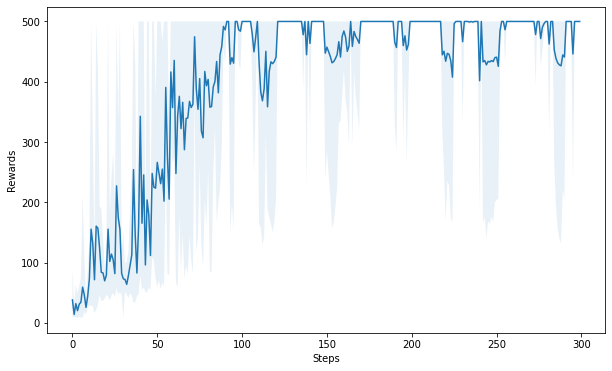

In [31]:
idxs = range(max_episodes)
fig, ax = plt.subplots(1, figsize=(10,6))
ax.plot(idxs, test_rewards.mean(0))
ax.fill_between(idxs, test_rewards.min(0).values, test_rewards.max(0).values, alpha=0.1)
ax.set_xlabel('Steps')
ax.set_ylabel('Rewards');

In [32]:
x = torch.randn(2, 10)
y = torch.randn(2, 10)
print(F.smooth_l1_loss(x, y))
print(F.mse_loss(x, y)) 

tensor(0.6398)
tensor(1.8497)




```
# This is formatted as code
```





```
# This is formatted as code
```

